In [62]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [63]:
import os, random, cv2, numpy as np, pandas as pd, torch, albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import sys
import glob
import time
import matplotlib.pyplot as plt

IMG_SIZE      = 256
BATCH_SIZE    = 32
LR            = 1e-4
WEIGHT_DECAY  = 1e-5

##  giving more weight(POS_WEIGHT) to tumor pixels  
## - since in BCE loss model can minimize by just predicting background everywhere
## intution- make tumor pixel 2x important than bg pixels
POS_WEIGHT    = 2.0           
NUM_WORKERS   = 4

DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR      = '/kaggle/working/weights_unet'
os.makedirs(SAVE_DIR, exist_ok=True)


In [64]:
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"


In [65]:
data=[]
for sub_dir_path in glob.glob(DATA_PATH+"*"):
  if os.path.isdir(sub_dir_path): ## to ignore data.csv 
    dirname=sub_dir_path.split("/")[-1]
    for filename in os.listdir(sub_dir_path):
      image_path=sub_dir_path+"/"+filename
      data.extend([dirname,image_path])
          
df=pd.DataFrame({
  "dirname":data[::2],
  "path":data[1::2]
})


In [66]:
df.head()

dirname                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [67]:
#for sorting 
BASE_LEN=89      # "/data/archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_"
END_IMG_LEN=4    #".tif"
END_MASK_LEN=9   #"_mask.tif"

In [68]:
df_images=df[~df["path"].str.contains("mask")]
df_masks=df[df["path"].str.contains("mask")]

images =sorted(df_images["path"].values ,key=lambda x:int(x[BASE_LEN:-END_IMG_LEN]))
masks =sorted(df_masks["path"].values ,key=lambda x:int(x[BASE_LEN:-END_MASK_LEN]))


In [69]:
# Sorting check
idx = random.randint(0, len(images)-1)
print("Path to the Image:", images[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_13.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_13_mask.tif


In [70]:
df=pd.DataFrame({
  "patient":df_images.dirname.values,
  "image_path":images,
  "mask_path":masks
})

In [71]:
def isTumor(path):
  max_pixel=np.max(cv2.imread(path))  #  return np array cv2.imread(path) and None if wrong path
  if max_pixel>0:
    return 1       ## 0 means black , so if >0 i.e 255 return tumor
  else:
    return 0
  
df["is_tumor"]=df["mask_path"].apply(lambda x:isTumor(x))


In [72]:
df.head()

patient                                         image_path  \
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path  is_tumor  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         0  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         0  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         0  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         0  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         0

In [73]:
df["is_tumor"].value_counts()

is_tumor
0    2556
1    1373
Name: count, dtype: int64

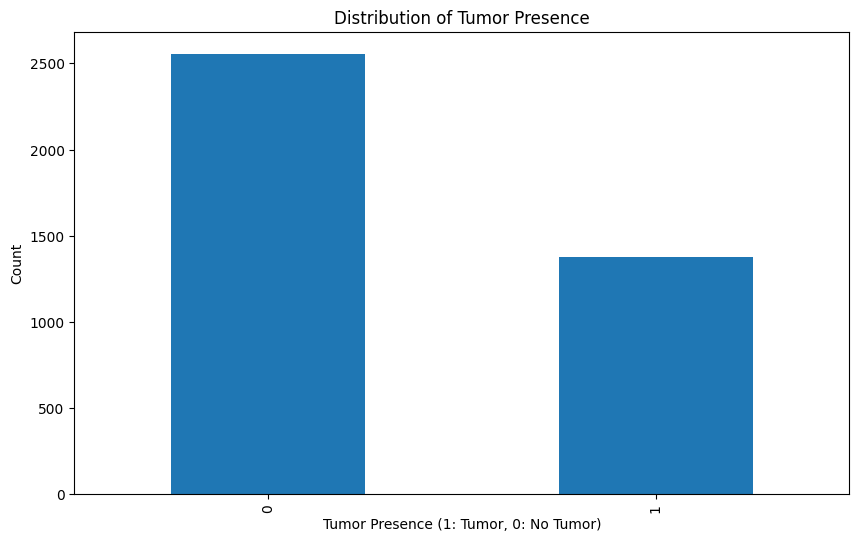

In [74]:
df["is_tumor"].value_counts().plot(kind="bar",title="Distribution of Tumor Presence", figsize=(10, 6))
plt.xlabel("Tumor Presence (1: Tumor, 0: No Tumor)")
plt.ylabel("Count") 
plt.show()

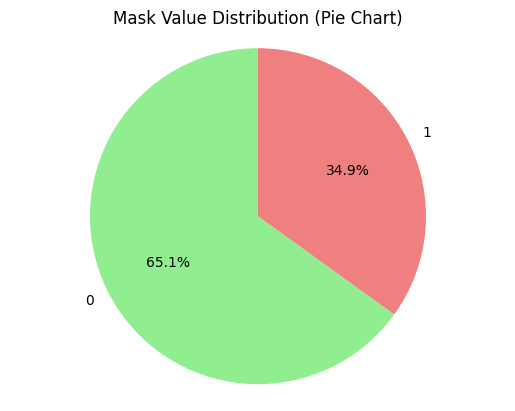

In [75]:
counts = df["is_tumor"].value_counts()
labels = counts.index.astype(str)
colors = ['lightgreen', 'lightcoral']

plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Mask Value Distribution (Pie Chart)")
plt.axis('equal')  # Makes the pie circular
plt.show()


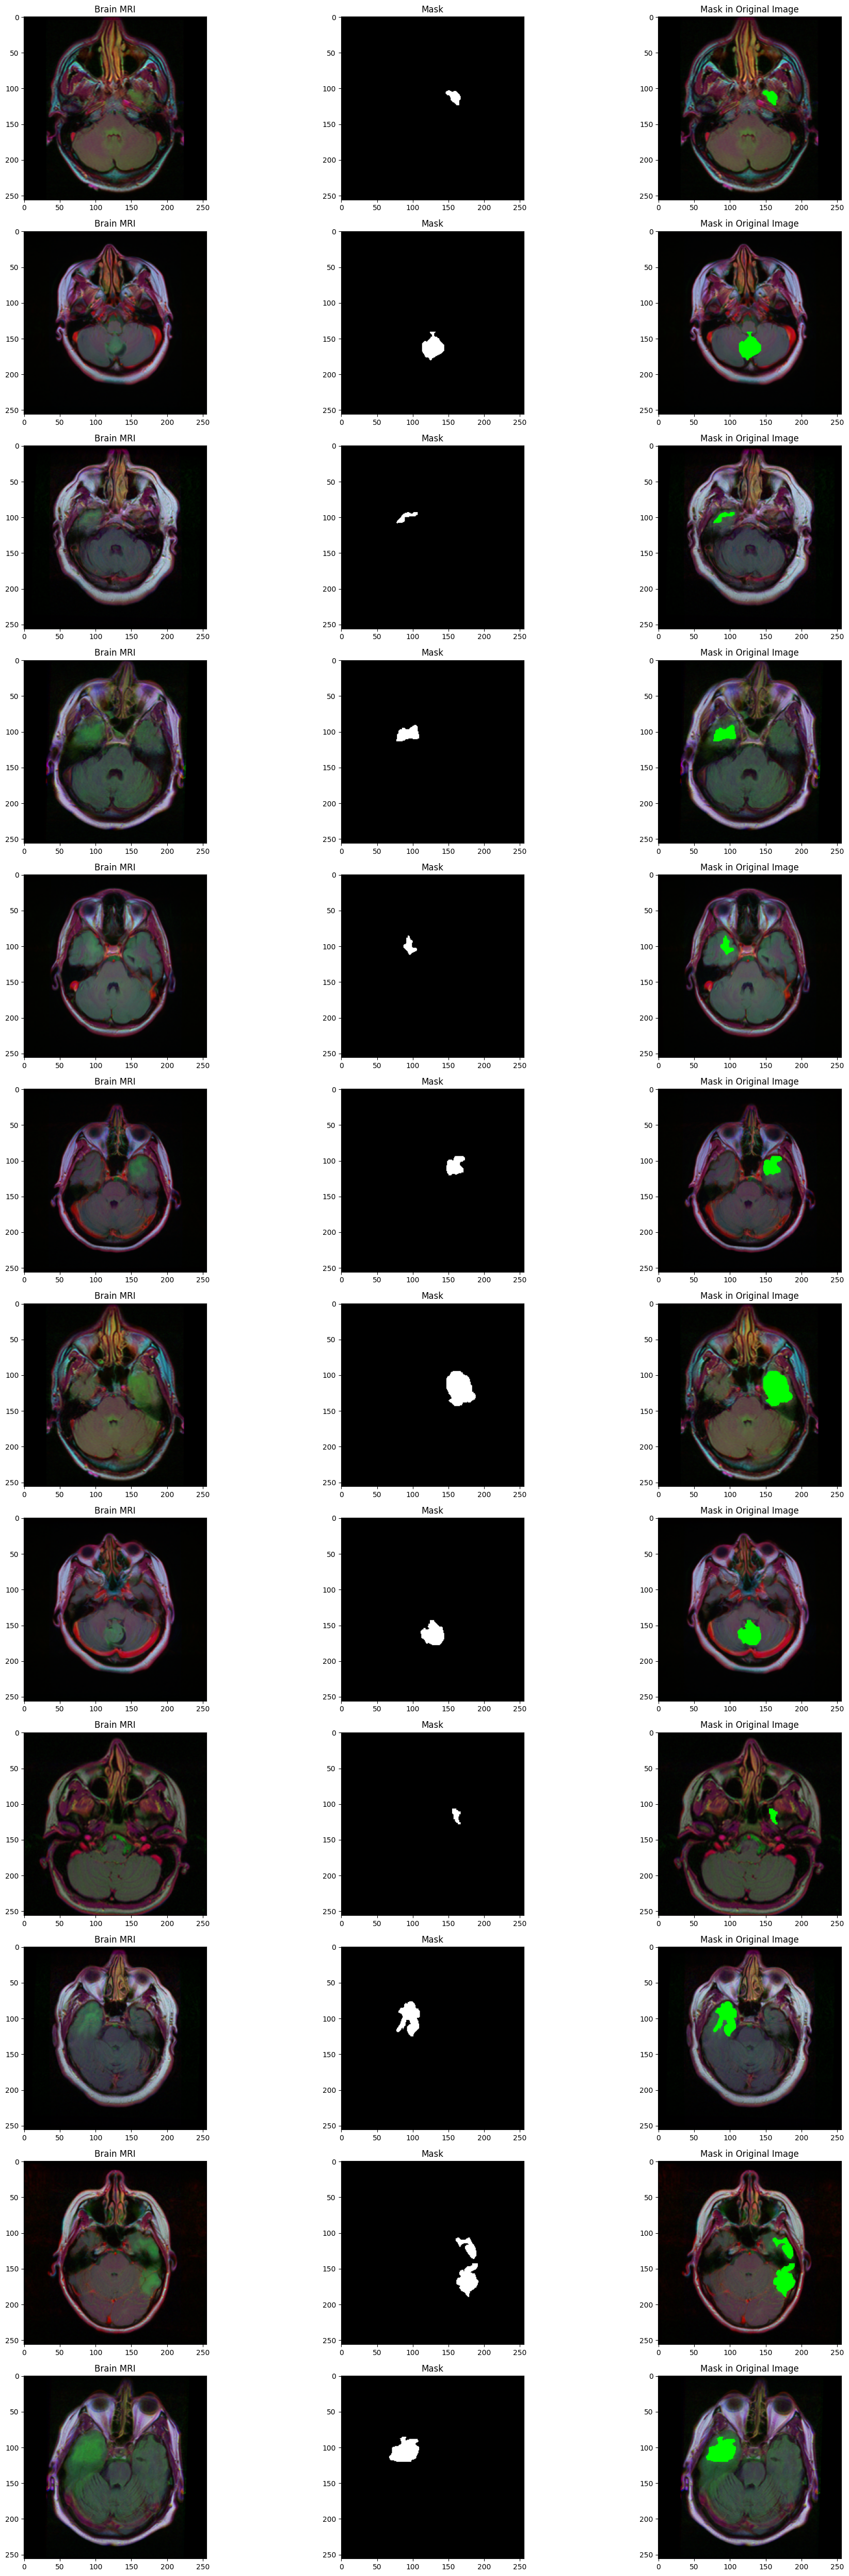

In [76]:
## visualize the mri scans and thier mask

count=0
fig,axs=plt.subplots(12,3,figsize=(20,50))
for i in range(len(df)):
  if(df.loc[i,"is_tumor"]==1 and count<12):
    img=cv2.imread(df.loc[i,"image_path"])
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    mask=cv2.imread(df.loc[i,"mask_path"])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask,cmap='gray')

    ## replace mask in original image
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    img[mask_gray == 255] = (0, 255, 0)
    axs[count][2].title.set_text("Mask in Original Image")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

In [77]:
# DATSET AND AUGMENTATION

In [78]:
class MRIDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.df  = dataframe.reset_index(drop=True)
        self.tfm = transforms

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.df.loc[idx, 'image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  ## cv2 read image in BGR format
        msk = cv2.imread(self.df.loc[idx, 'mask_path'], cv2.IMREAD_GRAYSCALE)

        if self.tfm:
            out   = self.tfm(image=img, mask=msk)
            img, msk = out['image'], out['mask']

        msk = msk.float().unsqueeze(0) / 255.  ## make pixels value from 0 -1 
        return img, msk

# augmentations 
train_tf = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.Normalize(), ToTensorV2(),
    ])
val_tf = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(), ToTensorV2(),
    ])


In [79]:
train_df, val_df = train_test_split(df, test_size=0.10, stratify=df.is_tumor, random_state=42)
train_df, test_df = train_test_split(train_df, test_size=0.15, stratify=train_df.is_tumor, random_state=42)

train_ds = MRIDataset(train_df, train_tf)
val_ds   = MRIDataset(val_df,   val_tf)
test_ds  = MRIDataset(test_df,  val_tf)

train_dl = DataLoader(train_ds, BATCH_SIZE, True,  num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds,   BATCH_SIZE, False, num_workers=NUM_WORKERS, pin_memory=True)
test_dl  = DataLoader(test_ds,  BATCH_SIZE, False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"train {len(train_ds)}  val {len(val_ds)}  test {len(test_ds)}")


train 3005  val 393  test 531


In [80]:
### MODEL

## UNET PARTS

class DoubleConv(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.conv=nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
      nn.ReLU(inplace=True)
    )
    
  def forward(self,x):
    return self.conv(x)
  
class DownSample(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.conv=DoubleConv(in_channels,out_channels)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)

  def forward(self,x):
    down=self.conv(x)
    p=self.pool(down)
    return down,p
  
class UpSample(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.up=nn.ConvTranspose2d(in_channels,in_channels//2,kernel_size=2,stride=2)
    self.conv=DoubleConv(in_channels,out_channels)

  def forward(self,x1,x2):
    x1=self.up(x1)
    x=torch.cat([x1,x2],1)
    return self.conv(x)
  



In [81]:
## UNET 

class UNet(nn.Module):
  def __init__(self,in_channels,num_classes):
    super().__init__()
    self.down_convolution_1 = DownSample(in_channels, 64)
    self.down_convolution_2 = DownSample(64, 128)
    self.down_convolution_3 = DownSample(128, 256)
    self.down_convolution_4 = DownSample(256, 512)

    self.bottleneck=DoubleConv(512,1024)

    self.up_convolution_1 = UpSample(1024, 512)
    self.up_convolution_2 = UpSample(512, 256)
    self.up_convolution_3 = UpSample(256, 128)
    self.up_convolution_4 = UpSample(128, 64)
    
    self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)
    

  def forward(self, x):                          
       down_1, p1 = self.down_convolution_1(x)   
       down_2, p2 = self.down_convolution_2(p1)  
       down_3, p3 = self.down_convolution_3(p2)  
       down_4, p4 = self.down_convolution_4(p3)  

       b = self.bottleneck(p4)                   

       up_1 = self.up_convolution_1(b, down_4)   
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out



In [82]:
pos_w = torch.tensor([POS_WEIGHT], device=DEVICE)
bce_logits = nn.BCEWithLogitsLoss(pos_weight=pos_w)

def dice_coef(probs, targets, eps=1e-7):
    inter = (probs * targets).sum(dim=(2,3))
    union = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    dice  = (2*inter + eps) / (union + eps)
    return dice.mean()

def dice_loss(probs, targets): return 1 - dice_coef(probs, targets)

def criterion(logits, targets):
    bce  = bce_logits(logits, targets)
    probs = torch.sigmoid(logits)
    return bce + dice_loss(probs, targets)


In [ ]:

model = UNet(in_channels=3, num_classes=1).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=LR, weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',factor=0.5,patience=3,verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [84]:
###TRAINING

In [85]:
# # --------------- HYPER-PARAMS ---------------
# EPOCHS            = 60          # maximum epochs
# ES_PATIENCE       = 6           # stop after 6 epochs without val-Dice gain
# best_val          = 0.0
# epochs_no_improve = 0
# # --------------------------------------------

# for epoch in range(1, EPOCHS + 1):

#     # =============== TRAIN ===================
#     model.train()
#     tot_loss, tot_dice = 0.0, 0.0

#     for step, (imgs, msks) in enumerate(train_dl, 1):
#         imgs, msks = imgs.to(DEVICE), msks.to(DEVICE)

#         optimizer.zero_grad()
#         logits = model(imgs)
#         loss   = criterion(logits, msks)
#         loss.backward()
#         optimizer.step()

#         batch_dice = dice_coef(torch.sigmoid(logits), msks).item()
#         tot_loss  += loss.item() * imgs.size(0)
#         tot_dice  += batch_dice   * imgs.size(0)

#         # ----- live console output -----
#         print(f"Epoch {epoch:02d} | Step {step:03d}/{len(train_dl)} "
#               f"| Loss {loss.item():.4f} | Dice {batch_dice:.4f}")

#     train_loss = tot_loss / len(train_ds)
#     train_dice = tot_dice / len(train_ds)

#     # ============== VALIDATION ===============
#     model.eval()
#     val_dice = 0.0
#     with torch.no_grad():
#         for imgs, msks in val_dl:
#             imgs, msks = imgs.to(DEVICE), msks.to(DEVICE)
#             probs = torch.sigmoid(model(imgs))
#             val_dice += dice_coef(probs, msks).item() * imgs.size(0)
#     val_dice /= len(val_ds)

#     scheduler.step(val_dice)

#     print(f"[{epoch:02d}]  train_loss={train_loss:.4f}  "
#           f"train_dice={train_dice:.4f}  val_dice={val_dice:.4f}")

#     # ============ CHECKPOINTING ==============
#     torch.save({"epoch": epoch,
#                 "model_state": model.state_dict(),
#                 "opt_state":   optimizer.state_dict(),
#                 "val_dice":    val_dice},
#                f"{SAVE_DIR}/unet_epoch_{epoch}.pth")

#     if val_dice > best_val:            # new best model
#         best_val = val_dice
#         torch.save(model.state_dict(), f"{SAVE_DIR}/unet_best.pth")
#         print(f"  ↳ NEW BEST (val Dice = {best_val:.4f})")
#         epochs_no_improve = 0
#     else:                              # no improvement
#         epochs_no_improve += 1
#         print(f"  ↳ no improvement for {epochs_no_improve} epoch(s)")

#     # ============ EARLY STOP ================
#     if epochs_no_improve >= ES_PATIENCE:
#         print(f"\nEarly stopping triggered — "
#               f"no val-Dice improvement in {ES_PATIENCE} consecutive epochs.")
#         break


In [86]:
## resuming traing from epoch 56

In [87]:
RESUME_PATH = f"{SAVE_DIR}/unet_epoch_56.pth"   # <- change if needed
print(RESUME_PATH)

/kaggle/working/weights_unet/unet_epoch_56.pth


In [88]:
# # ---------- RESUME SECTION ----------
# RESUME_PATH = f"{SAVE_DIR}/unet_epoch_55.pth"   # <- change if needed

# if os.path.exists(RESUME_PATH):
#     ckpt = torch.load(RESUME_PATH, map_location=DEVICE)

#     model.load_state_dict(ckpt["model_state"])
#     optimizer.load_state_dict(ckpt["opt_state"])
#     # If you also saved scheduler state you can restore it:
#     # scheduler.load_state_dict(ckpt["sched_state"])

#     start_epoch        = ckpt["epoch"] + 1      # next epoch to run
#     best_val           = ckpt["val_dice"]       # best Dice so far
#     epochs_no_improve  = 0                      # reset or restore if saved

#     print(f"✓  Resumed from {RESUME_PATH}")
#     print(f"   -> continuing at epoch {start_epoch}")
#     print(f"   -> best val Dice so far = {best_val:.4f}")
# else:
#     print("✓  No resume checkpoint found, training from scratch.")
#     start_epoch        = 1          # usual cold start
#     best_val           = 0.0
#     epochs_no_improve  = 0
# # ------------------------------------


In [89]:
# # --------------- HYPER-PARAMS ---------------
# EPOCHS            = 80          # maximum epochs
# ES_PATIENCE       = 6           # stop after 6 epochs without val-Dice gain
# best_val          = 0.0
# epochs_no_improve = 0
# # --------------------------------------------

# for epoch in range(start_epoch, EPOCHS + 1):

#     # =============== TRAIN ===================
#     model.train()
#     tot_loss, tot_dice = 0.0, 0.0

#     for step, (imgs, msks) in enumerate(train_dl, 1):
#         imgs, msks = imgs.to(DEVICE), msks.to(DEVICE)

#         optimizer.zero_grad(set_to_none=True)
#         logits = model(imgs)
#         loss   = criterion(logits, msks)
#         loss.backward()
#         optimizer.step()

#         batch_dice = dice_coef(torch.sigmoid(logits), msks).item()
#         tot_loss  += loss.item() * imgs.size(0)
#         tot_dice  += batch_dice   * imgs.size(0)

#         # ----- live console output -----
#         print(f"Epoch {epoch:02d} | Step {step:03d}/{len(train_dl)} "
#               f"| Loss {loss.item():.4f} | Dice {batch_dice:.4f}")

#     train_loss = tot_loss / len(train_ds)
#     train_dice = tot_dice / len(train_ds)

#     # ============== VALIDATION ===============
#     model.eval()
#     val_dice = 0.0
#     with torch.no_grad():
#         for imgs, msks in val_dl:
#             imgs, msks = imgs.to(DEVICE), msks.to(DEVICE)
#             probs = torch.sigmoid(model(imgs))
#             val_dice += dice_coef(probs, msks).item() * imgs.size(0)
#     val_dice /= len(val_ds)

#     scheduler.step(val_dice)

#     print(f"[{epoch:02d}]  train_loss={train_loss:.4f}  "
#           f"train_dice={train_dice:.4f}  val_dice={val_dice:.4f}")

#     # ============ CHECKPOINTING ==============
#     torch.save({"epoch": epoch,
#                 "model_state": model.state_dict(),
#                 "opt_state":   optimizer.state_dict(),
#                 "val_dice":    val_dice},
#                f"{SAVE_DIR}/unet_epoch_{epoch}.pth")

#     if val_dice > best_val:            # new best model
#         best_val = val_dice
#         torch.save(model.state_dict(), f"{SAVE_DIR}/unet_best.pth")
#         print(f"  ↳ NEW BEST (val Dice = {best_val:.4f})")
#         epochs_no_improve = 0
#     else:                              # no improvement
#         epochs_no_improve += 1
#         print(f"  ↳ no improvement for {epochs_no_improve} epoch(s)")

#     # ============ EARLY STOP ================
#     if epochs_no_improve >= ES_PATIENCE:
#         print(f"\nEarly stopping triggered — "
#               f"no val-Dice improvement in {ES_PATIENCE} consecutive epochs.")
#         break

In [90]:
## testing

In [95]:
best_model_PATH = "/kaggle/working/weights_unet/unet_best.pth"  

## loading model
best_model=torch.load(best_model_PATH,map_location=DEVICE)
model.load_state_dict(best_model)


print("Unet model inference")

model.eval()

test_loss, test_dice, num_samples = 0.0, 0.0, 0

with torch.no_grad():
    for step, (imgs, msks) in enumerate(test_dl, 1):
        imgs, msks = imgs.to(DEVICE), msks.to(DEVICE)

        logits = model(imgs)
        probs  = torch.sigmoid(logits)

        loss = criterion(logits, msks)
        dice = dice_coef(probs, msks)

        bs = imgs.size(0)           # current batch size
        test_loss += loss.item()  * bs
        test_dice += dice.item()  * bs
        num_samples += bs

        print(f"Step {step:03d}/{len(test_dl)} | "
              f"Loss {loss.item():.4f} | Dice {dice.item():.4f}")

test_loss /= num_samples
test_dice /= num_samples
print(f"\nTest Loss: {test_loss:.4f} | Test Dice: {test_dice:.4f}")

    
        


Unet model inference
Step 001/17 | Loss 0.2181 | Dice 0.8685
Step 002/17 | Loss 0.1050 | Dice 0.9132
Step 003/17 | Loss 0.1913 | Dice 0.8993
Step 004/17 | Loss 0.2324 | Dice 0.8338
Step 005/17 | Loss 0.2039 | Dice 0.8463
Step 006/17 | Loss 0.1434 | Dice 0.8934
Step 007/17 | Loss 0.1878 | Dice 0.8349
Step 008/17 | Loss 0.2390 | Dice 0.7916
Step 009/17 | Loss 0.1598 | Dice 0.8824
Step 010/17 | Loss 0.1058 | Dice 0.9256
Step 011/17 | Loss 0.1763 | Dice 0.8602
Step 012/17 | Loss 0.1540 | Dice 0.8777
Step 013/17 | Loss 0.1302 | Dice 0.9169
Step 014/17 | Loss 0.0789 | Dice 0.9595
Step 015/17 | Loss 0.1958 | Dice 0.8729
Step 016/17 | Loss 0.1690 | Dice 0.8671
Step 017/17 | Loss 0.3805 | Dice 0.7764

Test Loss: 0.1758 | Test Dice: 0.8741


In [97]:
## vistualise and infernce images

In [108]:
tumor_df

patient  \
541   TCGA_DU_7300_19910814   
2120  TCGA_CS_4941_19960909   
2804  TCGA_DU_5855_19951217   
2638  TCGA_DU_7309_19960831   
2112  TCGA_CS_5397_20010315   
...                     ...   
2847  TCGA_DU_7298_19910324   
2159  TCGA_HT_7874_19950902   
3350  TCGA_DU_8168_19970503   
1358  TCGA_DU_8164_19970111   
2369  TCGA_DU_6405_19851005   

                                             image_path  \
541   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2120  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2804  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2638  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2112  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
2847  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2159  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3350  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1358  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2369  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  is_tumor  
541   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         1  
2120  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         1  
2804  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         1  
2638  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         1  
2112  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         1  
...                                                 ...       ...  
2847  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         1  
2159  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         1  
3350  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         1  
1358  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         1  
2369  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...         1  

[186 rows x 4 columns]

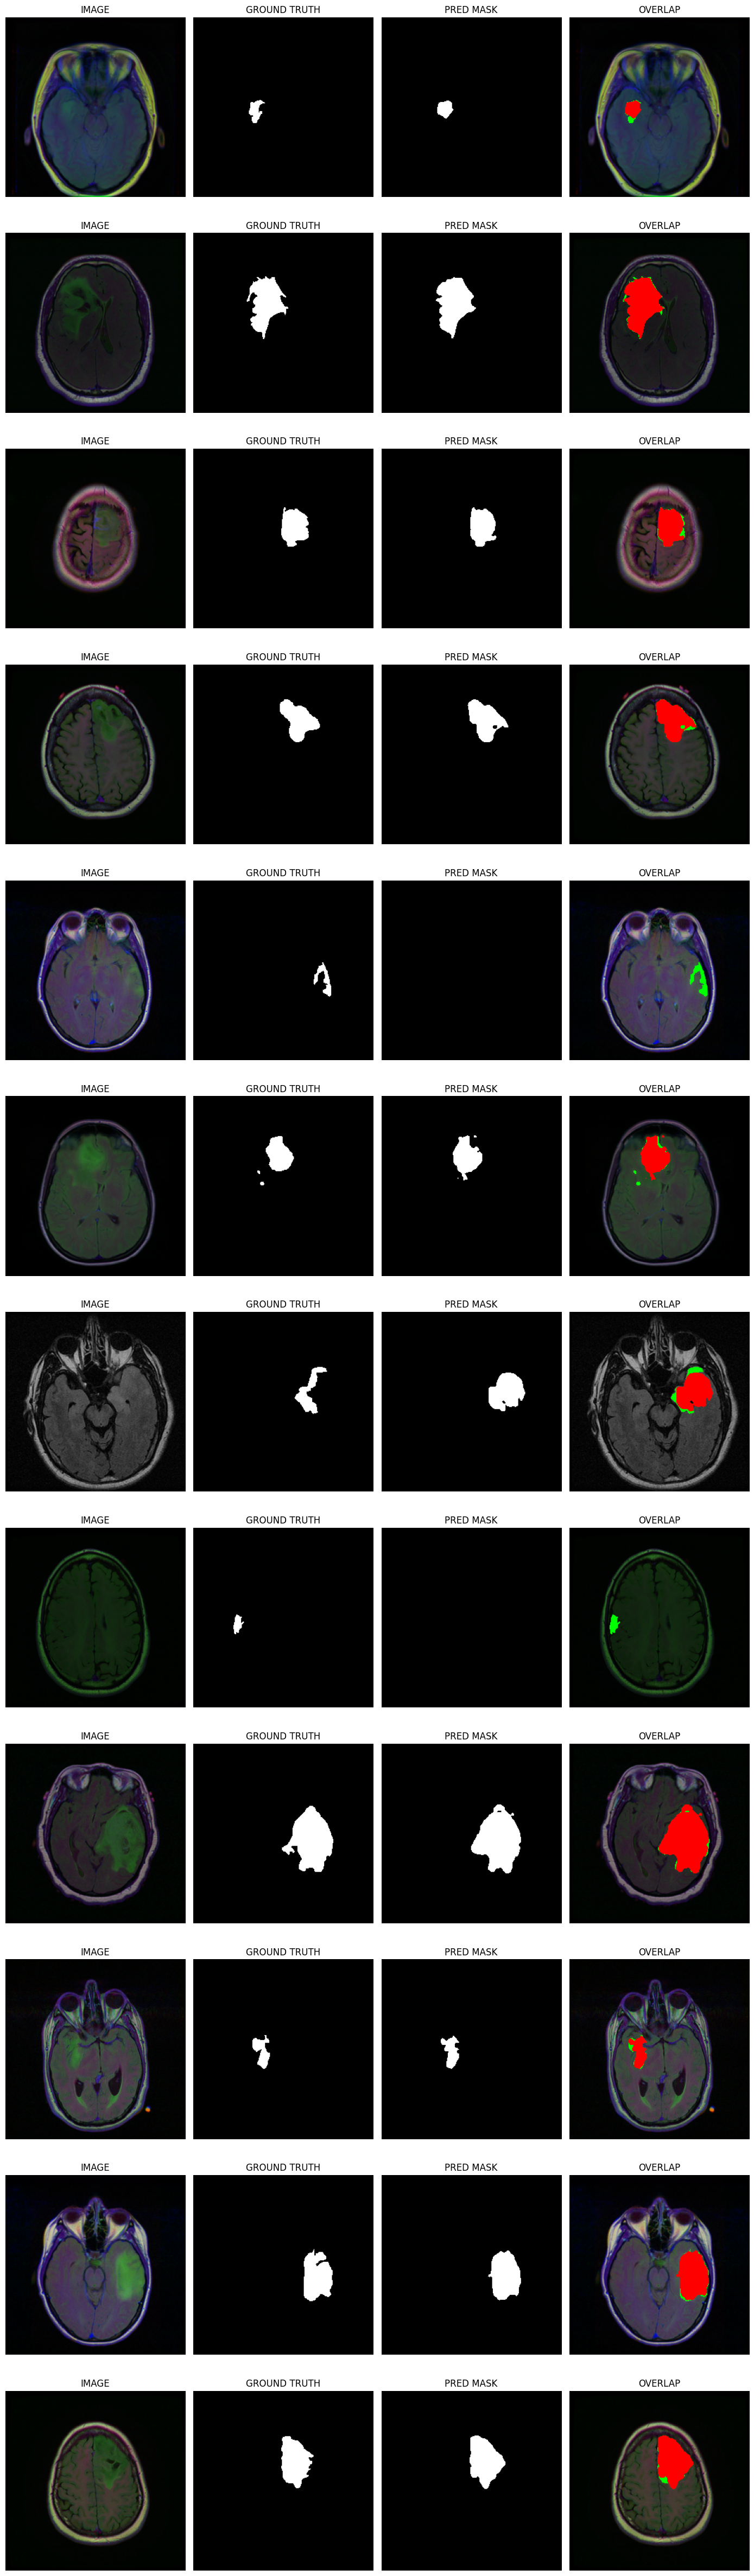

In [ ]:
# make sure the helper is defined
def plot_plate_overlap(batch_preds, title, num):
    plt.figure(figsize=(15, 15))
    plt.imshow(batch_preds)
    plt.axis("off")

    plt.figtext(0.76,0.75,"Green - Ground Truth", va="center",
                ha="center", size=20, color="lime")
    plt.figtext(0.26,0.75,"Red - Prediction",  va="center",
                ha="center", size=20, color="#ff0d00")
    plt.suptitle(title, y=.80, fontsize=20, weight="bold", color="#00FFDE")

    fn = "_".join((title+str(num)).lower().split()) + ".png"
    plt.savefig(fn, bbox_inches='tight', pad_inches=0.2,
                transparent=False, facecolor='black')
    plt.close()


tumor_df = test_df[test_df["is_tumor"] == 1]

model.eval()

n_rows = 12
fig, ax = plt.subplots(n_rows, 4, figsize=(14, 4 * n_rows))

with torch.no_grad():
    for i in range(n_rows):

        idx        = np.random.choice(tumor_df.index)
        img_path   = tumor_df.loc[idx, "image_path"]
        mask_path  = tumor_df.loc[idx, "mask_path"]

        rgb_orig   = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask_orig  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


        sample       = val_tf(image=rgb_orig, mask=mask_orig)
        x            = sample["image"].unsqueeze(0).to(DEVICE)   # 1×3×H×W
        gt_mask_norm = sample["mask"]        # torch tensor, values 0…255

        gt_mask = (gt_mask_norm.numpy() > 127).astype(np.uint8)


        logits = model(x)
        prob   = torch.sigmoid(logits)[0, 0].cpu().numpy()
        pred_mask = (prob > 0.5).astype(np.uint8)


        overlap = rgb_orig.copy()
        overlap[gt_mask == 1]   = [0, 255, 0]      # ground truth  → green
        overlap[pred_mask == 1] = [255, 0, 0]      # prediction    → red


        plot_plate_overlap(overlap, "Overlap", i)


        ax[i, 0].imshow(rgb_orig)
        ax[i, 0].set_title("IMAGE")
        ax[i, 1].imshow(mask_orig, cmap="gray")
        ax[i, 1].set_title("GROUND TRUTH")
        ax[i, 2].imshow(pred_mask * 255, cmap="gray")
        ax[i, 2].set_title("PRED MASK")
        ax[i, 3].imshow(overlap)
        ax[i, 3].set_title("OVERLAP")

        for j in range(4):
            ax[i, j].axis("off")

plt.tight_layout()
plt.show()
